In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm
import joblib

In [4]:
from hit_finding.constants import *
from hit_finding.metrics import *

In [5]:
from reproducibility.ReproducibilityContext import ReproducibilityContext
from reproducibility.ReproducibilityStrategy import *
from reproducibility.FilterStrategy import *

# Compare Hits Reproduction

In [6]:
zscores = extract_scores_from_all(extract_score, threshold=4)
joined = pd.concat(zscores.values())
joined.shape

...................................

(11197, 18)

In [7]:
joined.columns

Index(['AGP_map', 'DNA_map', 'ER_map', 'Mito_map', 'RNA_map', 'ALL_map',
       'AGP_raw', 'DNA_raw', 'ER_raw', 'Mito_raw', 'RNA_raw', 'ALL_raw',
       'AGP_raw1to1', 'DNA_raw1to1', 'ER_raw1to1', 'Mito_raw1to1',
       'RNA_raw1to1', 'ALL_raw1to1'],
      dtype='object')

In [16]:
joined.filter(regex='(?<!ALL)_map$').columns

Index(['AGP_map', 'DNA_map', 'ER_map', 'Mito_map', 'RNA_map'], dtype='object')

In [32]:
topk_filter=400
filter_strg = TopKFilterStrategy(topk_filter)

In [33]:
mtch_fltr = MatchFilterDecorator(filter_strg, joined.filter(regex=f'_map$'), 'ALL_map')

In [34]:
mtch_fltr.filter_dataframe(joined.filter(regex=f'_raw$'), 'ALL_raw').index.get_level_values(1).value_counts()

BRD-K54233340-300-01-0    3
BRD-K43389675-003-02-7    3
BRD-K54095730-001-01-5    3
BRD-K56064827-001-04-7    3
BRD-K52313696-001-01-6    3
                         ..
BRD-K49111258-001-02-8    1
BRD-K19576518-001-09-9    1
BRD-K14096728-001-05-7    1
BRD-K99978353-001-06-4    1
BRD-K77834935-001-01-3    1
Name: Metadata_broad_sample, Length: 284, dtype: int64

In [12]:
rep_cont = ReproducibilityContext(None, None)
topk_filter=10
filter_strg = TopKFilterStrategy(topk_filter)
rep_strg = MeanDistanceStrategy()
rep_cont.filter_strategy = filter_strg
rep_cont.reproducibility_strategy = rep_strg
method='map'
cur = joined.filter(regex=f'_{method}')

cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')

In [13]:
rep_cont.filter_strategy.get_filter_threshold()

0.785024154589372

In [ ]:
rep_cont = ReproducibilityContext(None, None)
res = dict()
for method in ['map', 'raw']:
    res[method] = dict()
    cur = joined.filter(regex=f'_{method}$')

    res[method]['abs'] = dict()
    for rep_name in ['mean', 'chan_vector']:
            res[method]['abs'][rep_name] = []
            
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
            
    res[method]['topk'] = dict()
    for rep_name in ['mean', 'chan_vector']:
        res[method]['topk'][rep_name] = []
        
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['topk'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_6797/311177651.py:17: RuntimeWarning: invalid value encountered in double_scalars
  metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
rep_cont = ReproducibilityContext(None, None)
for method in ['map', 'raw']:
    cur = joined.filter(regex=f'_{method}$')

    for rep_name in ['corr_p', 'corr_s']:
            res[method]['abs'][rep_name] = []
            
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        for rep_name, rep_strg in zip(['corr_p', 'corr_s'], [CorrelationStrategy('pearson', corr_sign=-1), CorrelationStrategy('spearman', corr_sign=-1)]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
            
    filter_dict = {
        'topk': TopKFilterStrategy,
        'topkfdup': TopKFromDupFilterStrategy,
        'topkfdupwmch': TopKFromDupWithMatchFilterStrategy
    }
    
    for k in filter_dict.keys():
        if k not in res[method].keys():
            res[method][k] = dict()
            
    for filter_name, filter_cls in filter_dict.items():
        for rep_name, rep_strg in zip(['corr_p', 'corr_s'], [CorrelationStrategy('pearson', corr_sign=-1), CorrelationStrategy('spearman', corr_sign=-1)]):
            res[method][filter_name][rep_name] = []
            rep_cont.reproducibility_strategy = rep_strg
            for topk_filter in tqdm(range(50, 1001, 50)):
                filter_strg = filter_cls(topk_filter)
                rep_cont.filter_strategy = filter_strg
                    
                cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
                metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
                del cur_res
                res[method][filter_name][rep_name].append((topk_filter, metric))
                joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/16 [00:00<?, ?it/s]

/home/naorko/.conda/envs/tf-env/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/naorko/.conda/envs/tf-env/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/tmp/ipykernel_31409/974913155.py:14: RuntimeWarning: invalid value encountered in double_scalars
  metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
rep_cont = ReproducibilityContext(None, None)
for method in ['map', 'raw']:
    cur = joined.filter(regex=f'_{method}$')

    reps = [('speci', SpecificityStrategy())]
    for rep_name, _ in reps:
            res[method]['abs'][rep_name] = []
            
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        rep_cont.filter_strategy = filter_strg
        for rep_name, rep_strg in reps:
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
            
    filter_dict = {
        'topk': TopKFilterStrategy,
        'topkfdup': TopKFromDupFilterStrategy,
#         'topkfdupwmch': TopKFromDupWithMatchFilterStrategy
    }
    
    for k in filter_dict.keys():
        if k not in res[method].keys():
            res[method][k] = dict()
            
    for filter_name, filter_cls in filter_dict.items():
        for rep_name, rep_strg in reps:
            res[method][filter_name][rep_name] = []
            rep_cont.reproducibility_strategy = rep_strg
            for topk_filter in tqdm(range(50, 1001, 50)):
                filter_strg = filter_cls(topk_filter)
                rep_cont.filter_strategy = filter_strg
                    
                cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
                metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
                del cur_res
                res[method][filter_name][rep_name].append((topk_filter, metric))
                joblib.dump(res, '/home/naorko/res_dict.sav')

In [41]:
rep_cont = ReproducibilityContext(None, None)
for method in ['map', 'raw']:
    cur = joined.filter(regex=f'_{method}$')
            
    res[method]['abs']['uniqueness'] = []      
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        for rep_name, rep_strg in zip(['uniqueness'], [UniquenessStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            metric = rep_cont.dataframe_measure(cur, f'ALL_{method}')
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
    
    filter_dict = {
        'topk': TopKFilterStrategy,
        'topkfdup': TopKFromDupFilterStrategy,
        'topkfdupwmch': TopKFromDupWithMatchFilterStrategy
    }
    
    for k in filter_dict.keys():
        if k not in res[method].keys():
            res[method][k] = dict()
    
    for filter_name, filter_cls in filter_dict.items():
        res[method][filter_name]['uniqueness'] = []
        for topk_filter in tqdm(range(50, 1001, 50)):
            filter_strg = filter_cls(topk_filter)
            for rep_name, rep_strg in zip(['uniqueness'], [UniquenessStrategy()]):
                rep_cont.filter_strategy = filter_strg
                rep_cont.reproducibility_strategy = rep_strg
                metric = rep_cont.dataframe_measure(cur, f'ALL_{method}')
                res[method][filter_name][rep_name].append((topk_filter, metric))
                joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
rep_cont = ReproducibilityContext(None, None)
for method in ['map', 'raw']:
    cur = joined.filter(regex=f'_{method}$')
    
    res[method]['topkfdup']['chan_vector'] = []
    res[method]['topkfdup']['mean'] = []
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFromDupFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['topkfdup'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

    res[method]['topkfdupwmch']['chan_vector'] = []
    res[method]['topkfdupwmch']['mean'] = []
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFromDupWithMatchFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['topkfdupwmch'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/20 [00:00<?, ?it/s]

## Load measures

In [8]:
res = joblib.load('/home/naorko/res_dict.sav')

In [9]:
for k1, v1 in res.items():
    print(k1)
#     print('\t', v1.keys())
    for k2, v2 in v1.items():
        print('\t', k2)
#         print('\t', '\t', list(v2.keys()))
        for k3, v3 in v2.items():
            print('\t', '\t', k3, len(list(zip(*v3))[0]))
#             print('\t', '\t',  '\t', list(zip(*v3))[0])

map
	 abs
	 	 mean 16
	 	 chan_vector 16
	 	 uniqueness 16
	 	 corr_p 16
	 	 corr_s 16
	 	 speci 16
	 topk
	 	 mean 20
	 	 chan_vector 20
	 	 uniqueness 20
	 	 corr_p 20
	 	 corr_s 20
	 	 speci 20
	 topkfdup
	 	 uniqueness 20
	 	 chan_vector 20
	 	 mean 20
	 	 corr_p 20
	 	 corr_s 20
	 	 speci 20
	 topkfdupwmch
	 	 uniqueness 20
	 	 chan_vector 20
	 	 mean 20
	 	 corr_p 20
	 	 corr_s 20
raw
	 abs
	 	 mean 16
	 	 chan_vector 16
	 	 uniqueness 16
	 	 corr_p 16
	 	 corr_s 16
	 	 speci 16
	 topk
	 	 mean 20
	 	 chan_vector 20
	 	 uniqueness 20
	 	 corr_p 20
	 	 corr_s 20
	 	 speci 20
	 topkfdup
	 	 uniqueness 20
	 	 chan_vector 20
	 	 mean 20
	 	 corr_p 20
	 	 corr_s 20
	 	 speci 20
	 topkfdupwmch
	 	 uniqueness 20
	 	 chan_vector 20
	 	 mean 20
	 	 corr_p 20
	 	 corr_s 20


## Plot measures

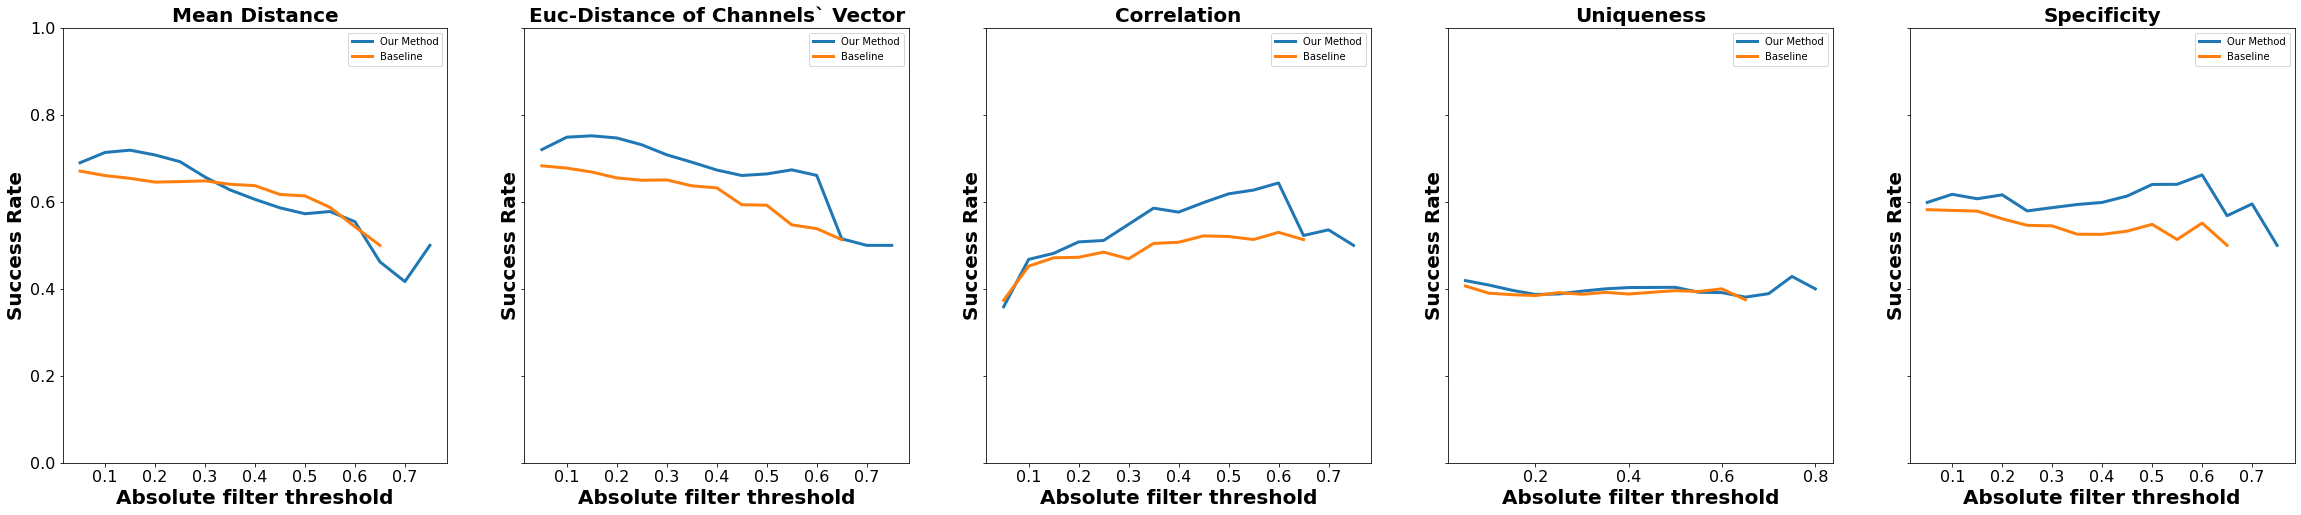

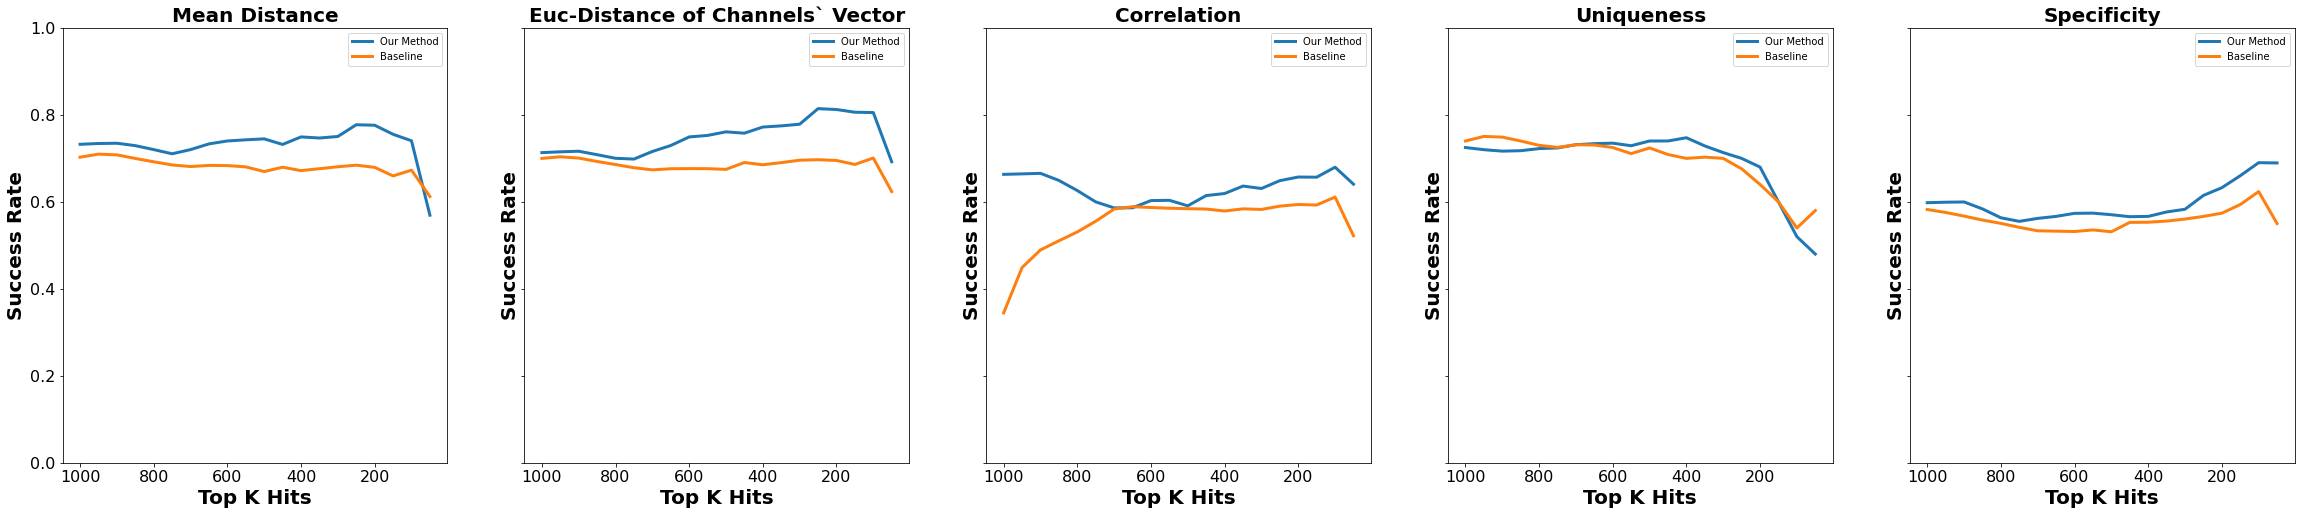

In [12]:
filter_name_dict = {
    'abs': 'Absolute filter threshold',
#     'topk': 'Top K from all',
    'topkfdup': 'Top K from replicates', 
#     'topkfdupwmch': 'Top K from replicates with outers'
}
rep_name_dict = {
    'mean': 'Mean Distance', 
    'chan_vector': 'Euc-Distance of Channels` Vector', #'Hit Reproducibility'
    'corr_p': 'Correlation',#'Pearson Correlation',
#     'corr_s': 'Spearman Correlation',
    'uniqueness': 'Uniqueness',
    'speci': 'Specificity'
}

for filter_type, filter_name in filter_name_dict.items():
    ncols = len(rep_name_dict)
    fig, ax = plt.subplots(ncols=ncols, figsize=(ncols*8,8), sharey=True, facecolor='white')#, sharex=True)
#     fig.suptitle(f'Filter - {filter_name}')
    
    for i, (metric, metric_name) in enumerate(rep_name_dict.items()):
        
        for method in ['map', 'raw']:
            if metric in res[method][filter_type].keys():
                x, y = zip(*res[method][filter_type][metric])
                ax[i].plot(x, y, linewidth=3)
    
        if 'topk' in filter_type:
            ax[i].invert_xaxis()
            ax[i].set_xlabel('Top K Hits', fontweight="bold", fontsize=20)
        else:
            ax[i].set_xlabel('Absolute filter threshold', fontweight="bold", fontsize=20)
            
        ax[i].legend(['Our Method', 'Baseline'])
        ax[i].set_ylim((0,1))
        
        ax[i].set_title(metric_name, fontweight="bold", fontsize=20)
        ax[i].set_ylabel('Success Rate', fontweight="bold", fontsize=20)
        ax[i].xaxis.set_tick_params(labelsize=16)
        ax[i].yaxis.set_tick_params(labelsize=16)

## Filter top K real threshold

In [17]:
filter_dict = {
    'topk': TopKFilterStrategy,
    'topkfdup': TopKFromDupFilterStrategy,
    'topkfdupwmch': TopKFromDupWithMatchFilterStrategy
}

filter_ths = dict()
for f_name, f_cls in filter_dict.items():
    filter_ths[f_name] = dict()
    for method in ['map', 'raw']:
        filter_ths[f_name][method] = []
        cur = joined.filter(regex=f'_{method}$')
        
        for topk_filter in tqdm(range(50, 1001, 50)):
            f = f_cls(topk_filter)
            _ = f.filter_dataframe(cur, f'ALL_{method}')
            th = f.get_filter_threshold()
            filter_ths[f_name][method].append((topk_filter, th))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

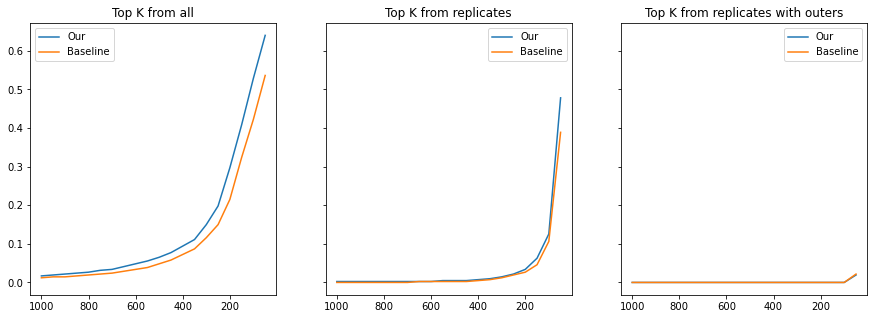

In [18]:
name_dict = {
    'topk': 'Top K from all',
    'topkfdup': 'Top K from replicates', 
    'topkfdupwmch': 'Top K from replicates with outers'
}

fig, ax = plt.subplots(ncols=3, figsize=(3*5,5), sharey=True, sharex=True)

for i, (f_name, f_full_name) in enumerate(name_dict.items()):
    ax[i].set_title(f_full_name)
        
    for method in ['map', 'raw']:
        x, y = zip(*filter_ths[f_name][method])
        ax[i].plot(x, y)

    ax[i].invert_xaxis()
    ax[i].legend(['Our', 'Baseline'])

In [ ]:
import os
job_cancel_str="scancel " + os.environ['SLURM_JOBID']
os.system(job_cancel_str)